In [12]:
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.profiler import profile, record_function, ProfilerActivity, tensorboard_trace_handler

from datasets import load_dataset
from transformers import AutoTokenizer
import numpy as np
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)


Device: cuda


In [3]:
raw_ds = load_dataset('ag_news')
TOKENIZER_NAME = 'bert-base-uncased'
MAX_LEN = 64
BATCH_SIZE = 64

tokenizer = AutoTokenizer.from_pretrained(TOKENIZER_NAME)

def tokenize_batch(batch):
    return tokenizer(batch['text'], padding='max_length', truncation=True, max_length=MAX_LEN)

raw_ds = raw_ds.map(tokenize_batch, batched=True)
raw_ds.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
train_loader = DataLoader(raw_ds['train'], batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(raw_ds['test'], batch_size=1, shuffle=False)

print('Dataset ready. Vocab size:', tokenizer.vocab_size)

Map:   0%|          | 0/7600 [00:00<?, ? examples/s]

Dataset ready. Vocab size: 30522


In [75]:
class EarlyExitTransformer(nn.Module):
    def __init__(self, vocab_size, d_model=128, nhead=4, dim_feedforward=256, num_layers=6,
                 exit_layer_indices=None, max_len=MAX_LEN, num_classes=4, pad_token_id=0):
        super().__init__()
        self.d_model = d_model
        self.vocab_size = vocab_size
        self.token_embed = nn.Embedding(vocab_size, d_model, padding_idx=pad_token_id)
        self.pos_embed = nn.Embedding(max_len, d_model)
        self.layers = nn.ModuleList([
            nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward, activation='relu')
            for _ in range(num_layers)
        ])
        if exit_layer_indices is None:
            # default: 3 exit points evenly spaced (0-indexed)
            exit_layer_indices = [num_layers//3 - 1, 2*num_layers//3 - 1, num_layers - 1]
        self.exit_layer_indices = exit_layer_indices
        self.classifiers = nn.ModuleList([nn.Linear(d_model, num_classes) for _ in exit_layer_indices])
        self.num_layers = num_layers
        self.max_len = max_len

    def forward_full(self, input_ids, attention_mask):
        # input_ids: [batch, seq_len], attention_mask: [batch, seq_len]
        batch, seq_len = input_ids.size()
        device = input_ids.device
        pos_ids = torch.arange(seq_len, dtype=torch.long, device=device).unsqueeze(0).expand(batch, -1)

        x = self.token_embed(input_ids) + self.pos_embed(pos_ids)
        # Transformer expects (seq, batch, d_model)
        x = x.transpose(0,1)

        logits_list = []
        exit_idx = 0
        for layer_idx, layer in enumerate(self.layers):
            # src_key_padding_mask expects True at positions that are masked (i.e., pad tokens)
            src_key_padding_mask = (attention_mask == 0)
            x = layer(x, src_key_padding_mask=src_key_padding_mask)
            if layer_idx in self.exit_layer_indices:
                # pool: mean pooling over non-padded tokens
                x_t = x.transpose(0,1)  # [batch, seq, d]
                mask = attention_mask.unsqueeze(-1).float()  # [batch, seq, 1]
                summed = (x_t * mask).sum(dim=1)  # [batch, d]
                lengths = mask.sum(dim=1).clamp(min=1.0)  # avoid div by zero
                pooled = summed / lengths
                logits = self.classifiers[exit_idx](pooled)
                logits_list.append(logits)
                exit_idx += 1
        return logits_list  # list of tensors [batch, num_classes]

    def predict_until_exit(self, input_ids, attention_mask, tau=0.9):
        # Per-sample early exit inference (sequentially run layers until confidence >= tau).
        # Returns predicted label, confidence, exit_layer_index (actual layer index used)
        device = input_ids.device
        batch, seq_len = input_ids.size()
        assert batch == 1, 'predict_until_exit is implemented for single sample (batch=1)'

        pos_ids = torch.arange(seq_len, dtype=torch.long, device=device).unsqueeze(0)
        x = self.token_embed(input_ids) + self.pos_embed(pos_ids)
        x = x.transpose(0,1)  # [seq, 1, d]
        src_key_padding_mask = (attention_mask == 0)

        exit_idx = 0
        for layer_idx, layer in enumerate(self.layers):
            x = layer(x, src_key_padding_mask=src_key_padding_mask)
            if layer_idx in self.exit_layer_indices:
                x_t = x.transpose(0,1)  # [1, seq, d]
                mask = attention_mask.unsqueeze(-1).float()
                summed = (x_t * mask).sum(dim=1)
                lengths = mask.sum(dim=1).clamp(min=1.0)
                pooled = summed / lengths
                logits = self.classifiers[exit_idx](pooled)
                probs = F.softmax(logits, dim=1)
                conf, pred = torch.max(probs, dim=1)
                conf_val = conf.item()
                pred_val = pred.item()
                if conf_val >= tau:
                    return logits, layer_idx, conf_val
                exit_idx += 1
        # no early exit -> return final head's output
        # use last classifier's logits
        logits = logits.detach()
        probs = F.softmax(logits, dim=1)
        conf, pred = torch.max(probs, dim=1)
        return logits, self.num_layers - 1, conf.item()


In [77]:
NUM_LAYERS = 6
EXIT_LAYERS = [1, 3, 5]  # 0-indexed; will place classifiers after these layers
model = EarlyExitTransformer(vocab_size=tokenizer.vocab_size, d_model=128, nhead=4,
                             dim_feedforward=256, num_layers=NUM_LAYERS,
                             exit_layer_indices=EXIT_LAYERS, max_len=MAX_LEN,
                             num_classes=4, pad_token_id=tokenizer.pad_token_id)
model.to(device)
print(model)

EarlyExitTransformer(
  (token_embed): Embedding(30522, 128, padding_idx=0)
  (pos_embed): Embedding(64, 128)
  (layers): ModuleList(
    (0-5): 6 x TransformerEncoderLayer(
      (self_attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
      )
      (linear1): Linear(in_features=128, out_features=256, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (linear2): Linear(in_features=256, out_features=128, bias=True)
      (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (dropout1): Dropout(p=0.1, inplace=False)
      (dropout2): Dropout(p=0.1, inplace=False)
    )
  )
  (classifiers): ModuleList(
    (0-2): 3 x Linear(in_features=128, out_features=4, bias=True)
  )
)


In [78]:
LOAD_CHECKPOINT = False  #  set False if you want to retrain from scratch

model = EarlyExitTransformer(
    vocab_size=tokenizer.vocab_size,
    d_model=128,
    nhead=4,
    dim_feedforward=256,
    num_layers=NUM_LAYERS,
    exit_layer_indices=EXIT_LAYERS,
    max_len=MAX_LEN,
    num_classes=4,
    pad_token_id=tokenizer.pad_token_id
).to(device)

if LOAD_CHECKPOINT:
    model.load_state_dict(torch.load("early_exit_model.pt", map_location=device))
    model.eval()
    print("Loaded pretrained checkpoint ")
else:
    print("Training from scratch… run Cell 5 next.")


Training from scratch… run Cell 5 next.


In [79]:
if not LOAD_CHECKPOINT:
    EPOCHS = 3
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    num_exits = len(EXIT_LAYERS)
    weights = [1.0/num_exits] * num_exits  # equal weights

    for epoch in range(EPOCHS):
        model.train()
        total_loss = 0.0
        total_samples = 0
        for batch in train_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            logits_list = model.forward_full(input_ids, attention_mask)

            # combine losses from all exits
            loss = sum(weights[i] * F.cross_entropy(logits, labels)
                       for i, logits in enumerate(logits_list))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * input_ids.size(0)
            total_samples += input_ids.size(0)

        print(f"Epoch {epoch+1}/{EPOCHS}, Avg Loss: {total_loss/total_samples:.4f}")


    torch.save(model.state_dict(), "early_exit_model.pt")
    print("Model saved ")


Epoch 1/3, Avg Loss: 0.4779
Epoch 2/3, Avg Loss: 0.2674
Epoch 3/3, Avg Loss: 0.2102
Model saved 


In [80]:
model.eval()
correct_full = 0
total = 0
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        logits_list = model.forward_full(input_ids, attention_mask)
        # use final exit's logits as baseline
        final_logits = logits_list[-1]
        preds = torch.argmax(final_logits, dim=1)
        correct_full += (preds == labels).sum().item()
        total += labels.size(0)
print(f"Full-model baseline accuracy: {correct_full/total:.4f} on test set")



Full-model baseline accuracy: 0.9076 on test set


In [81]:
taus = [round(t, 2) for t in np.linspace(0.5, 0.99, 10)]

results = {}

print("Evaluating early-exit model across tau thresholds...")
for tau in taus:
    correct, total = 0, 0
    total_layers, total_latency = 0, 0
    exit_layers_used = []

    model.eval()
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            # per-sample early exit
            for i in range(input_ids.size(0)):
                single_input = input_ids[i].unsqueeze(0)
                single_mask = attention_mask[i].unsqueeze(0)
                label = labels[i].unsqueeze(0)

                start = time.time()
                logits, exit_layer, conf = model.predict_until_exit(single_input, single_mask, tau=tau)
                latency = time.time() - start

                pred = logits.argmax(dim=-1)
                correct += (pred == label).sum().item()
                total += 1

                total_layers += exit_layer
                total_latency += latency
                exit_layers_used.append(exit_layer)

    acc = correct / total
    avg_layers = total_layers / total
    avg_latency = total_latency / total

    results[tau] = {
        "accuracy": acc,
        "avg_layers": avg_layers,
        "latency_s": avg_latency,
        "exit_layers_used": exit_layers_used
    }
    print(f"tau={tau:.2f}: acc={acc:.4f}, avg_layers={avg_layers:.2f}, latency={avg_latency*1000:.2f} ms")

#  Baseline (full model, no early exit)
model.eval()
correct_full, total = 0, 0
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        logits_list = model.forward_full(input_ids, attention_mask)
        logits = logits_list[-1]  # final exit only
        preds = logits.argmax(dim=-1)

        correct_full += (preds == labels).sum().item()
        total += labels.size(0)

baseline_acc = correct_full / total
baseline_layers = NUM_LAYERS
# approximate latency scaling
baseline_latency = np.mean([results[t]["latency_s"] for t in taus]) * (baseline_layers / np.mean([results[t]["avg_layers"] for t in taus]))

print(f"\nFull-model baseline accuracy: {baseline_acc:.4f}")


Evaluating early-exit model across tau thresholds...
tau=0.50: acc=0.9092, avg_layers=1.03, latency=1.53 ms
tau=0.55: acc=0.9087, avg_layers=1.09, latency=1.60 ms
tau=0.61: acc=0.9082, avg_layers=1.16, latency=1.61 ms
tau=0.66: acc=0.9082, avg_layers=1.23, latency=1.58 ms
tau=0.72: acc=0.9079, avg_layers=1.31, latency=1.68 ms
tau=0.77: acc=0.9078, avg_layers=1.38, latency=1.84 ms
tau=0.83: acc=0.9078, avg_layers=1.49, latency=1.93 ms
tau=0.88: acc=0.9076, avg_layers=1.63, latency=2.00 ms
tau=0.94: acc=0.9076, avg_layers=1.94, latency=2.29 ms
tau=0.99: acc=0.9076, avg_layers=3.22, latency=3.16 ms

Full-model baseline accuracy: 0.9076


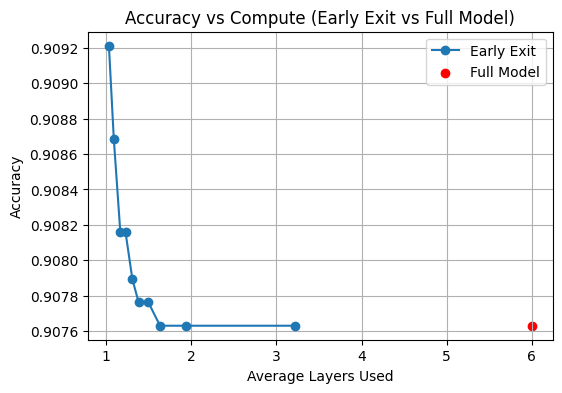

In [82]:
# Collect arrays for plotting
accs = [results[t]['accuracy'] for t in taus]
layers = [results[t]['avg_layers'] for t in taus]
latencies = [results[t]['latency_s']*1000 for t in taus]  # ms

# Accuracy vs Avg Layers Plot
plt.figure(figsize=(6,4))
plt.plot(layers, accs, marker='o', label='Early Exit')
plt.scatter([baseline_layers], [baseline_acc], color='red', label='Full Model')
plt.xlabel("Average Layers Used")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Compute (Early Exit vs Full Model)")
plt.legend()
plt.grid(True)
plt.show()


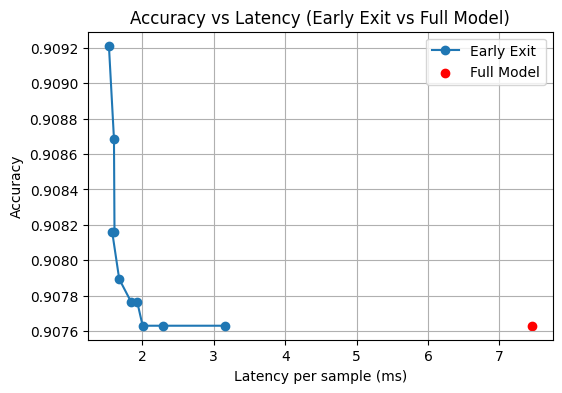

In [83]:
# Accuracy vs Latency Plot
plt.figure(figsize=(6,4))
plt.plot(latencies, accs, marker='o', label='Early Exit')
plt.scatter([baseline_latency*1000], [baseline_acc], color='red', label='Full Model')
plt.xlabel("Latency per sample (ms)")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Latency (Early Exit vs Full Model)")
plt.legend()
plt.grid(True)
plt.show()


C:\Users\parra\AppData\Local\Temp\ipykernel_26656\4172014052.py:12: UserWarning: Legend does not support handles for Annotation instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


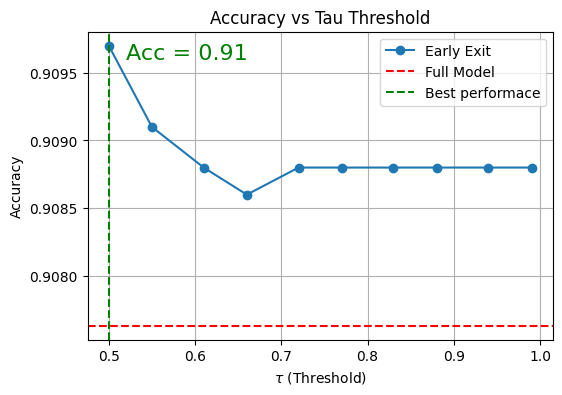

In [285]:
taus = [0.50, 0.55, 0.61, 0.66, 0.72, 0.77, 0.83, 0.88, 0.94, 0.99]
accs = [0.9097, 0.9091, 0.9088, 0.9086, 0.9088, 0.9088, 0.9088, 0.9088, 0.9088, 0.9088]

plt.figure(figsize=(6,4))
plt.plot(taus, accs, marker='o', label='Early Exit')
plt.axhline(y=baseline_acc, color='red', linestyle='--', label='Full Model')
plt.xlabel(r"$\tau$ (Threshold)")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Tau Threshold")
plt.annotate("Acc = 0.91", (0.52, 0.9096), fontsize=16, color='g', label='Best performace')
plt.axvline(0.5, color="g", linestyle='--', label='Best performace')
plt.legend()
plt.grid()
plt.savefig("tau_acc.png", dpi=200)
plt.show()


In [ ]:
# warm-up (important for CUDA/caching)
with torch.no_grad():
    for _ in range(10):
        _ = model.forward_full(input_ids[:4], attention_mask[:4])
        single_in = input_ids[0].unsqueeze(0)
        single_mask = attention_mask[0].unsqueeze(0)
        _ = model.predict_until_exit(single_in, single_mask, tau=0.9)

# Profile single-sample early exit (CPU + CUDA)
with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA],
             record_shapes=True, profile_memory=True, with_stack=False) as prof:
    with torch.no_grad():
        with record_function("predict_until_exit"):
            logits, exit_layer, conf = model.predict_until_exit(
                input_ids[0].unsqueeze(0), attention_mask[0].unsqueeze(0), tau=0.9
            )

# Print top ops
print(prof.key_averages().table(sort_by="self_cuda_time_total", row_limit=20))

In [ ]:
with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA],
             record_shapes=True, profile_memory=True) as prof2:
    with torch.no_grad():
        with record_function("forward_full"):
            logits_list = model.forward_full(input_ids[0].unsqueeze(0), attention_mask[0].unsqueeze(0))

print(prof2.key_averages().table(sort_by="self_cuda_time_total", row_limit=25))

In [186]:
times_ee = [275.903, 277.886, 297.025, 266.747, 282.717]
times_fm = [1.835, 2.036, 1.562, 1.806, 1.314]

# Calculate means and standard errors
mean_ee = np.mean(times_ee)
mean_fm = np.mean(times_fm) * 1000
se_ee = np.std(times_ee) / np.sqrt(len(times_ee))
se_fm = np.std(times_fm) * 1000 / np.sqrt(len(times_fm))

# Prepare data for plotting (log10 scale)
times = [np.log10(mean_ee), np.log10(mean_fm)]
errors = [se_ee / (mean_ee * np.log(10)), se_fm / (mean_fm * np.log(10))]  # Error propagation for log10

models = ["Early Exit (Acc = 0.91)", "Full Model (Acc = 0.91; baseline)"]

In [229]:
import scipy
times_fm = [i*1000 for i in times_fm]
test = scipy.stats.ttest_ind(times_fm, times_ee)
print(test)

TtestResult(statistic=np.float64(13.743523443045355), pvalue=np.float64(7.578024997303684e-07), df=np.float64(8.0))


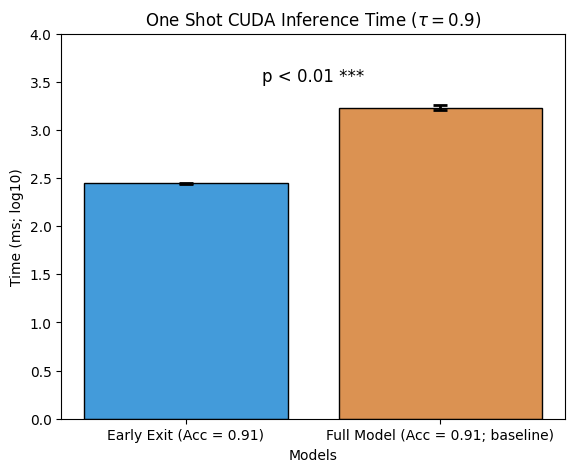

Early Exit: Mean = 280.06 μs, SE = 4.45 μs
Full Model: Mean = 1710.60 μs, SE = 111.33 μs


In [235]:
plt.figure(figsize=(6.5,5))
plt.bar(
    models, times, 
    yerr=errors, capsize=5, 
    error_kw={'elinewidth': 2, 'capthick': 2},
    color=["#439bda", "#db9252"],
    edgecolor='black'
)
plt.xlabel("Models")
plt.ylabel("Time (ms; log10)")
plt.title(r'One Shot CUDA Inference Time ($\tau = 0.9$)')
plt.ylim(0, 4)
plt.annotate("p < 0.01 ***", (0.3,3.5), fontsize=12)
plt.savefig("cuda_inference.png", dpi=200)
plt.show()

print(f"Early Exit: Mean = {mean_ee:.2f} μs, SE = {se_ee:.2f} μs")
print(f"Full Model: Mean = {mean_fm:.2f} μs, SE = {se_fm:.2f} μs")